# 概要
- IW（Inverse Weighting）推定量を用いて、未観察群の1975年所得（re75）を予測
- 目的変数: `log1p(re75)` - 対数変換により正規分布に近づける
- 観察確率（propensity score）に基づく重みでバイアスを補正

# 1. ライブラリのインポート

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# 2. データの読み込みと設定

In [ ]:
# データの読み込み
df = pd.read_csv('../data/ec675_nsw.tab', sep='\t')

# === 設定 ===
# 観察変数（treatment variable）
is_observed = 'is_observed'

# 目的変数（予測対象）
y_col = 're75'

# 観察有無の予測に使用する特徴量
X_cols_for_treatment = ['age', 'educ', 'nodegree', 're74', 'hisp', 'married']

# re75予測に使用する特徴量
X_cols_for_y = ['age', 'educ', 'nodegree', 're74', 'hisp', 'married']

print("=== 設定情報 ===")
print(f"観察変数: {is_observed}")
print(f"目的変数: {y_col}")
print(f"観察予測用特徴量: {X_cols_for_treatment}")
print(f"re75予測用特徴量: {X_cols_for_y}")

=== 設定情報 ===
介入変数: is_observed
目的変数: re75
介入予測用特徴量: ['age', 'educ', 'nodegree', 're74', 'hisp', 'married']
re75予測用特徴量: ['age', 'educ', 'nodegree', 're74', 'hisp', 'married']


# 3. データ前処理

In [155]:
# データの前処理
df_train = df.copy()
df_train = df_train.query('sample!=3')  # sample=3を除外
# sample2の群は10%だけランダムサンプリング
df_sample1 = df_train[df_train['sample'] == 1]
df_sample2 = df_train[df_train['sample'] == 2]#.sample(frac=0.3, random_state=42)
df_train = pd.concat([df_sample1, df_sample2], ignore_index=True)

print(f"sample=1のサンプル数: {len(df_sample1)}")
print(f"sample=2のサンプル数（10%サンプリング後）: {len(df_sample2)}")
print(f"合計サンプル数: {len(df_train)}")
# 欠損値処理
df_train = df_train.fillna(0)

# 観察有無を作成
# ここでは、簡易的に、実験対象であったかどうかとする
df_train['is_observed'] = np.where(df_train['sample'] == 1, 1, 0)

sample=1のサンプル数: 722
sample=2のサンプル数（10%サンプリング後）: 15992
合計サンプル数: 16714


## 観察有無による特徴量の分布の違いの確認
- 観察群と非観察群では、re75とその他の特徴量の相関に違いがありそう
- そのため、重み付き回帰分析を行うことで、観察効果のバイアスを補正することを目指す

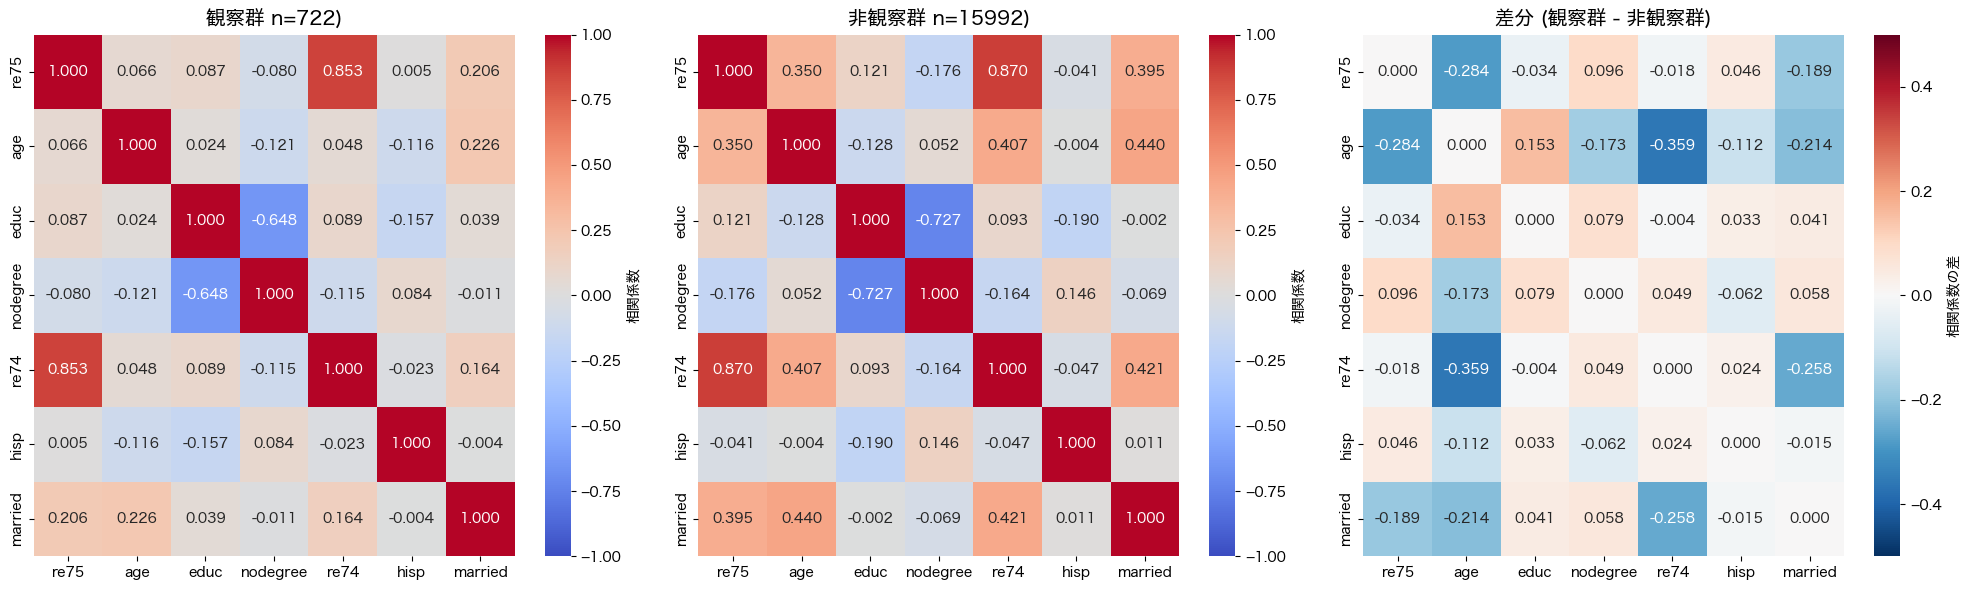

In [156]:
# Xで条件づけたとしても、特徴量の分布が異なることを示したい
# is_observedごとに、y_colとX_colsの相関係数行列をプロットする

# 観察群と非観察群に分割
df_treated_group = df_train[df_train[is_observed] == 1]
df_control_group = df_train[df_train[is_observed] == 0]

# 相関係数を計算する列を選択
corr_cols = [y_col] + X_cols_for_y

# それぞれの群で相関係数行列を計算
corr_treated = df_treated_group[corr_cols].corr()
corr_control = df_control_group[corr_cols].corr()

# 相関係数行列の差分を計算
corr_diff = corr_treated - corr_control

# 3つのヒートマップを並べて可視化
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
# 観察群の相関係数行列
sns.heatmap(corr_treated, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=axes[0], cbar_kws={'label': '相関係数'})
axes[0].set_title(f'観察群 n={len(df_treated_group)})', fontsize=14)
# 非観察群の相関係数行列
sns.heatmap(corr_control, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=axes[1], cbar_kws={'label': '相関係数'})
axes[1].set_title(f'非観察群 n={len(df_control_group)})', fontsize=14)
# 差分（観察群 - 非観察群）
sns.heatmap(corr_diff, annot=True, fmt='.3f', cmap='RdBu_r', 
            center=0, vmin=-0.5, vmax=0.5, ax=axes[2], cbar_kws={'label': '相関係数の差'})
axes[2].set_title('差分 (観察群 - 非観察群)', fontsize=14)
plt.tight_layout()
plt.show()


# 4. 観察確率モデルの構築（Propensity Score推定）

=== 観察確率モデルの評価 ===
ROC-AUC Score: 0.8852


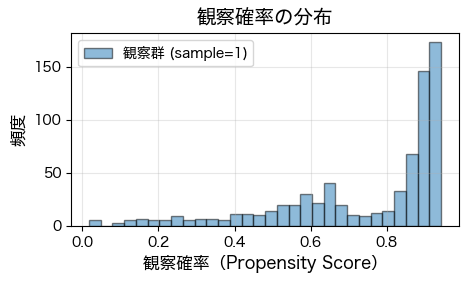

In [157]:
# 観察確率（propensity score）を推定するためのロジスティック回帰モデル
X_treatment = df_train[X_cols_for_treatment].values
y_treatment = df_train[is_observed].values

# ロジスティック回帰モデルの構築と学習
propensity_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
propensity_model.fit(X_treatment, y_treatment)

# 観察確率の予測
propensity_scores = propensity_model.predict_proba(X_treatment)[:, 1]

# 結果の確認
print("=== 観察確率モデルの評価 ===")
print(f"ROC-AUC Score: {roc_auc_score(y_treatment, propensity_scores):.4f}")

# 観察確率の分布を可視化
plt.figure(figsize=(5, 2.5))
plt.hist(propensity_scores[y_treatment == 1], bins=30, alpha=0.5, label='観察群 (sample=1)', edgecolor='black')
plt.xlabel('観察確率（Propensity Score）', fontsize=12)
plt.ylabel('頻度', fontsize=12)
plt.title('観察確率の分布', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. IW推定量の重み計算とクリッピング

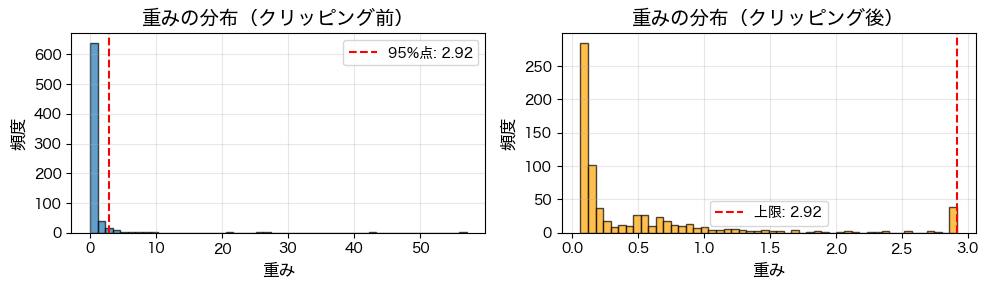

In [158]:
# IW推定量の重み計算: w = (1 - θ(X)) / θ(X)
# 観察群のデータに適用
df_treated = df_train[df_train[is_observed] == 1].copy()
propensity_treated = propensity_model.predict_proba(df_treated[X_cols_for_treatment].values)[:, 1]

# 重みの計算
weights = (1 - propensity_treated) / propensity_treated

# 重みのクリッピング（95パーセンタイル）
weight_cap = np.percentile(weights, 95)
weights_clipped = np.clip(weights, 0, weight_cap)

# 重みの分布を可視化
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# クリッピング前
axes[0].hist(weights, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(weight_cap, color='red', linestyle='--', label=f'95%点: {weight_cap:.2f}')
axes[0].set_xlabel('重み', fontsize=12)
axes[0].set_ylabel('頻度', fontsize=12)
axes[0].set_title('重みの分布（クリッピング前）', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# クリッピング後
axes[1].hist(weights_clipped, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(weight_cap, color='red', linestyle='--', label=f'上限: {weight_cap:.2f}')
axes[1].set_xlabel('重み', fontsize=12)
axes[1].set_ylabel('頻度', fontsize=12)
axes[1].set_title('重みの分布（クリッピング後）', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# データフレームに重みを追加
df_treated['weights'] = weights_clipped

# 6. 重み付き線形回帰モデルの学習

In [159]:
# 観察群のデータで学習
X_train_treated = df_treated[X_cols_for_y].values
y_train_treated = df_treated[y_col].values

# 重み付きランダムフォレスト回帰モデル
model_weighted = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model_weighted.fit(X_train_treated, y_train_treated, sample_weight=df_treated['weights'])

# 重みなしランダムフォレスト回帰モデル（比較用）
model_unweighted = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model_unweighted.fit(X_train_treated, y_train_treated)

print("=== モデル学習完了 ===")
print(f"学習データ数: {len(X_train_treated)}")
print(f"特徴量数: {len(X_cols_for_y)}")
print(f"\n重み付きモデルの特徴量重要度:")
for i, col in enumerate(X_cols_for_y):
    print(f"  {col}: {model_weighted.feature_importances_[i]:.4f}")

print(f"\n重みなしモデルの特徴量重要度:")
for i, col in enumerate(X_cols_for_y):
    print(f"  {col}: {model_unweighted.feature_importances_[i]:.4f}")

=== モデル学習完了 ===
学習データ数: 722
特徴量数: 6

重み付きモデルの特徴量重要度:
  age: 0.0636
  educ: 0.0431
  nodegree: 0.0054
  re74: 0.8755
  hisp: 0.0026
  married: 0.0099

重みなしモデルの特徴量重要度:
  age: 0.0621
  educ: 0.0401
  nodegree: 0.0058
  re74: 0.8733
  hisp: 0.0057
  married: 0.0130


# 7. 未観察群（sample=2）での予測と評価

In [160]:
# 未観察群のデータを取得
df_control = df_train[df_train[is_observed] == 0].copy()
X_control = df_control[X_cols_for_y].values
y_control_true = df_control[y_col].values

# 重み付きモデルで予測
y_pred_weighted = model_weighted.predict(X_control)

# 重みなしモデルで予測
y_pred_unweighted = model_unweighted.predict(X_control)

# 評価指標の計算
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n=== {model_name} ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

# 各モデルの評価
metrics_weighted = evaluate_model(y_control_true, y_pred_weighted, "重み付きモデル")
metrics_unweighted = evaluate_model(y_control_true, y_pred_unweighted, "重みなしモデル")

# 評価指標の比較
print("\n=== 評価指標の比較 ===")
comparison_df = pd.DataFrame({
    '重み付きモデル': [metrics_weighted['rmse'], metrics_weighted['mae'], metrics_weighted['r2']],
    '重みなしモデル': [metrics_unweighted['rmse'], metrics_unweighted['mae'], metrics_unweighted['r2']],
    '差分': [
        metrics_weighted['rmse'] - metrics_unweighted['rmse'],
        metrics_weighted['mae'] - metrics_unweighted['mae'],
        metrics_weighted['r2'] - metrics_unweighted['r2']
    ]
}, index=['RMSE', 'MAE', 'R²'])
print(comparison_df)


=== 重み付きモデル ===
RMSE: 6114.6689
MAE: 4803.8505
R² Score: 0.5649

=== 重みなしモデル ===
RMSE: 6503.7177
MAE: 5188.6211
R² Score: 0.5078

=== 評価指標の比較 ===
          重み付きモデル      重みなしモデル          差分
RMSE  6114.668856  6503.717661 -389.048805
MAE   4803.850524  5188.621139 -384.770615
R²       0.564913     0.507787    0.057127


# 8. 結果の可視化

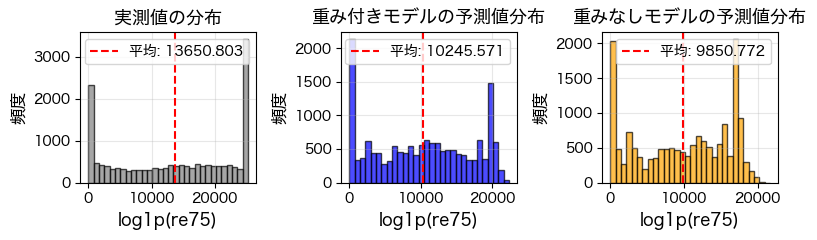

In [162]:
# 予測値の分布比較
fig, axes = plt.subplots(1, 3, figsize=(8, 2.5))

# 実測値の分布
axes[0].hist(y_control_true, bins=30, edgecolor='black', alpha=0.7, color='gray')
axes[0].set_xlabel('log1p(re75)', fontsize=12)
axes[0].set_ylabel('頻度', fontsize=12)
axes[0].set_title('実測値の分布', fontsize=13)
axes[0].axvline(y_control_true.mean(), color='red', linestyle='--', 
                label=f'平均: {y_control_true.mean():.3f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 重み付きモデルの予測値分布
axes[1].hist(y_pred_weighted, bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[1].set_xlabel('log1p(re75)', fontsize=12)
axes[1].set_ylabel('頻度', fontsize=12)
axes[1].set_title('重み付きモデルの予測値分布', fontsize=13)
axes[1].axvline(y_pred_weighted.mean(), color='red', linestyle='--',
                label=f'平均: {y_pred_weighted.mean():.3f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 重みなしモデルの予測値分布
axes[2].hist(y_pred_unweighted, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[2].set_xlabel('log1p(re75)', fontsize=12)
axes[2].set_ylabel('頻度', fontsize=12)
axes[2].set_title('重みなしモデルの予測値分布', fontsize=13)
axes[2].axvline(y_pred_unweighted.mean(), color='red', linestyle='--',
                label=f'平均: {y_pred_unweighted.mean():.3f}')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# まとめ

本ノートブックでは、IW推定量を用いて未観察群の1975年所得（re75）を予測しました。

## 手法のポイント
1. **目的変数の対数変換**: `log1p(re75)`により正規分布に近づけ、線形回帰の前提を満たしやすくしました
2. **観察確率モデル**: ロジスティック回帰で観察確率（propensity score）を推定
3. **重み計算**: IW推定量 `w = (1-θ)/θ` により選択バイアスを補正
4. **重みのクリッピング**: 95パーセンタイルで上限を設定し、極端な重みの影響を抑制
5. **重み付き線形回帰**: 観察群データに重みを適用して学習し、未観察群の所得を予測

## 結果の解釈
- 重み付きモデルと重みなしモデルの性能を比較することで、選択バイアス補正の効果を確認できます
- 予測値vs実測値のプロットで、モデルの予測精度を視覚的に評価できます
- 残差プロットで、モデルの偏りやパターンを確認できます